# Stream K算法

## 实验

### 实验设置

- 修改内核模块配置：`(echo 'options nvidia "NVreg_RestrictProfilingToAdminUsers=0"') | sudo tee -a /etc/modprobe.d/RestrictedProfiling.conf >/dev/null` 将配置选项添加到系统的模块配置文件中，使得所有用户而非仅限管理员能够进行 NVIDIA GPU 的性能分析

- 检查 NVIDIA 驱动的配置参数：`cat /proc/driver/nvidia/params | grep RmProfilingAdminOnly` 用来查看 NVIDIA 驱动的当前配置参数，验证前面修改的配置是否已生效

- 设置复现实验的设置
    - 启用 GPU 持久模式，使 GPU 在没有运行计算任务时不会关闭其电源状态，有助于避免启动计算时的延迟：`sudo nvidia-smi -pm 1 -i 0`
    - 设置 GPU 功率限制，确保 GPU 不会超过设定的功率使用阈值：`sudo nvidia-smi -i 0 -pl 350  # 400 for A100`
    - 锁定 GPU 时钟频率，提高运行实验的可重复性：`sudo nvidia-smi -i 0 -lgc 1005`

In [1]:
# (echo 'options nvidia "NVreg_RestrictProfilingToAdminUsers=0"') | sudo tee -a /etc/modprobe.d/RestrictedProfiling.conf >/dev/null
# sudo update-initramfs -u -k all
# cat /proc/driver/nvidia/params | grep RmProfilingAdminOnly
# sudo apt-get install zlib1g-dev
# for reproductible experiments
# sudo nvidia-smi -pm 1 -i 0
# sudo nvidia-smi -i 0 -pl 350  # 400 for A100
# sudo nvidia-smi -i 0 -lgc 1005

In [1]:
from typing import Optional
import torch
import triton
import triton.language as tl
from triton.runtime.driver import CudaUtils # V100上 ImportError: cannot import name 'CudaUtils' from 'triton.runtime.driver'

import random
import json

In [3]:
torch.manual_seed(2024)
random.seed(2024)

device = torch.cuda.current_device()
cuda_utils = CudaUtils()
total_sm = cuda_utils.get_device_properties(device)["multiprocessor_count"]
# total_sm = 84
print(f"total SMs: {total_sm}")

total SMs: 108


### Triton kernels

#### 映射方式
将当前计算单元的 ID tile_id 重新映射为 (pid_m, pid_n)

`swizzle_tile`：通过改变矩阵块（tile）的访问顺序来优化数据的 L2 缓存利用

- 将矩阵分块（BLOCK），进一步将矩阵块分组（GROUP），并在每个组内按特定的顺序访问块，以确保数据在被处理时尽可能地留在 L2 缓存中

    - width = GROUP_M * grid_n：一个组内包含的总块数
    - group_id = tile_id // width
    - group_size = min(grid_m - group_id * GROUP_M, GROUP_M)
    - pid_m = group_id * GROUP_M + (tile_id % group_size)
    - pid_n = (tile_id % width) // group_size  

`linear_tile`：简单线性映射
    
- 直接根据 `tile_id` 确定其在矩阵中的行和列位置，线性映射，从左到右，从上到下
    - pid_m = tile_id // grid_n
    - pid_n = tile_id % grid_n

In [4]:
@triton.jit()
def swizzle_tile(tile_id,
                 M, N, K,
                 BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
                 GROUP_M: tl.constexpr): # 重排序时，每组包含的行块数量
    # 计算矩阵在 M 和 N 方向上的块数，向下取整
    grid_m = tl.cdiv(M, BLOCK_M)
    grid_n = tl.cdiv(N, BLOCK_N)
    # 确定重新排序的宽度
    width = GROUP_M * grid_n
    # 计算组 ID 和 组内尺寸
    group_id = tile_id // width
    group_size = tl.minimum(grid_m - group_id * GROUP_M, GROUP_M) 
    # 确定行块和列块的位置
    pid_m = group_id * GROUP_M + (tile_id % group_size)
    pid_n = (tile_id % width) // group_size
    return pid_m, pid_n

@triton.jit()
def linear_tile(tile_id,
                M, N, K,
                BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
                GROUP_M: tl.constexpr):
    pid_m = tile_id // tl.cdiv(N, BLOCK_N)
    pid_n = tile_id %  tl.cdiv(N, BLOCK_N)
    return pid_m, pid_n

#### 第一部分 n-tile Stream-K

##### mac_loop()

- 使用Triton实现基于tile和iter的矩阵乘法

- 由于tiles可能被切分给不同的SMs，使用locks数组追踪每个 tile 的处理状态，保证数据一致性
    - 初始状态为 0
    - 如果当前迭代是一个 tile 的最后一次迭代，用 `tl.atomic_add` 将累加结果写回矩阵 C
    - 用 `tl.atomic_xchg` 将锁状态更新为 1，表示该 tile 已经被完整处理
    - 如果当前 tile 已经被部分处理，使用 `tl.atomic_cas` 确保其他计算单元在等待当前计算单元完成写入后再进行写入

In [5]:
@triton.jit()
def mac_loop(A, B, C,
             M, N, K,
             locks, # 用于在不同 GPU 线程之间同步的 locks 数组
             stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn, # 各个矩阵维度的步长
             iters_per_tile, # 一个 tile 中的迭代次数
             start_iter, end_iter,
             BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
             ACC_TYPE: tl.constexpr, # 用于计算的累加器类型，保证足够的数值精度
             GROUP_M: tl.constexpr):
    # 确定当前块的位置
    tile_id = start_iter // iters_per_tile
    if GROUP_M > 0:
        pid_m, pid_n = swizzle_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    else:
        pid_m, pid_n = linear_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    # 计算内存地址
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    rk = tl.arange(0, BLOCK_K)
    A = A + (rm[:, None] * stride_am + rk[None, :] * stride_ak) + BLOCK_K * stride_ak * (start_iter % iters_per_tile)
    B = B + (rk[:, None] * stride_bk + rn[None, :] * stride_bn) + BLOCK_K * stride_bk * (start_iter % iters_per_tile)
    # 初始化 BLOCK_M x BLOCK_N 的累加器
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=ACC_TYPE)
    # 执行矩阵乘法
    for current_iter in range(start_iter, end_iter):
        a = tl.load(A)
        b = tl.load(B)
        acc += tl.dot(a, b)
        A += BLOCK_K * stride_ak
        B += BLOCK_K * stride_bk
    # 写回结果
    # 最后一次迭代处理当前块，则将累加器中的结果写回到矩阵 C 的相应位置
    if end_iter % iters_per_tile == 0: # last iteration of the tile always happens before its start on another SM
        C_ = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)  # compute inside the if/else to avoid spilling!
        tl.store(C_, acc)
        if start_iter % iters_per_tile != 0:  # only if tile has been partially processed
            tl.atomic_xchg(locks + tile_id, 1)
    # 块已经被部分处理，使用原子交换（tl.atomic_xchg）来更新锁状态，确保结果的一致性
    else:
        while tl.atomic_cas(locks + tile_id, 1, 1) != 1:
            pass
        C_ = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)  # compute inside the if/else to avoid spilling!
        tl.atomic_add(C_, acc)

##### first_wave()
- 调用 `mac_loop()`处理分配不均的前几个tile

In [6]:
@triton.jit()
def first_wave(
        A, B, C,
        M, N, K,
        locks,
        stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
        total_full_tiles_streamk, total_partial_tiles_streamk, 
        iters_per_tile,
        BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr, ACC_TYPE: tl.constexpr,
        GROUP_M: tl.constexpr):
    pid = tl.program_id(0)
    start_iter = pid * total_full_tiles_streamk + tl.minimum(pid, total_partial_tiles_streamk)
    last_iter = (pid + 1) * total_full_tiles_streamk + tl.minimum(pid + 1, total_partial_tiles_streamk)

    while start_iter < last_iter:
        end_iter = tl.minimum(start_iter + (iters_per_tile - start_iter % iters_per_tile), last_iter)
        mac_loop(A, B, C,
                 M, N, K,
                 locks,
                 stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
                 iters_per_tile,
                 start_iter, end_iter,
                 BLOCK_M, BLOCK_N, BLOCK_K, ACC_TYPE,
                 GROUP_M,)

        start_iter = end_iter

#### 第二部分 Data-Parallel
##### full_tiles()
- 使用Triton实现处理完整 tiles 的矩阵乘法

In [7]:
@triton.jit()
def full_tiles(
        A, B, C,
        M, N, K,
        stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
        total_tiles_streamk,
        BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr, ACC_TYPE: tl.constexpr,
        GROUP_M: tl.constexpr,
):
    # 确定当前块的位置，total_tiles_streamk 是由 first_wave 处理的 tile 数量
    tile_id = tl.program_id(0) + total_tiles_streamk
    if GROUP_M > 0:
        pid_m, pid_n = swizzle_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    else:
        pid_m, pid_n = linear_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    # 计算内存地址
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    rk = tl.arange(0, BLOCK_K)
    A = A + (rm[:, None] * stride_am + rk[None, :] * stride_ak)
    B = B + (rk[:, None] * stride_bk + rn[None, :] * stride_bn)
    # 初始化 BLOCK_M x BLOCK_N 的累加器
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=ACC_TYPE)
    # 执行矩阵乘法
    for k in range(0, tl.cdiv(K, BLOCK_K)):
        a = tl.load(A)
        b = tl.load(B)
        acc += tl.dot(a, b)
        A += BLOCK_K * stride_ak
        B += BLOCK_K * stride_bk
    acc = acc.to(tl.float16)  # 将累加器 acc 的数据类型转换为 tl.float16，以匹配输出矩阵 C 的数据类型
    # 重新计算 rm 和 rn 以节省寄存器
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    C = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)
    tl.store(C, acc)

### GEMM Wrapper
- two_tiles 模式表示每个 Stream-K 任务处理两个 tiles


In [8]:
class matmul(torch.autograd.Function):
    _debug = False

    @staticmethod
    def set_debug(debug: bool):
        matmul._debug = debug

    @staticmethod
    def _call(a: torch.Tensor, b: torch.Tensor, 
              total_programs_streamk: int, 
              BLK_M: int, BLK_N: int, BLK_K: int, 
              two_tiles: bool, num_stages: int, num_warps: int):
        device = a.device

        # 确保输入的矩阵是连续存储的
        assert a.is_contiguous() and b.is_contiguous(), "输入的矩阵必须是连续的"
        assert a.shape[1] == b.shape[0], "矩阵维度不匹配"
        M, K = a.shape
        _, N = b.shape

        # 根据输入矩阵的数据类型选择累加器类型
        ACC_TYPE = tl.float32 if a.dtype in [torch.float16, torch.bfloat16, torch.float32] else tl.int32

        # 计算需要的块数和迭代次数
        total_blocks_M = triton.cdiv(M, BLK_M)
        total_blocks_N = triton.cdiv(N, BLK_N)
        iters_per_tile = triton.cdiv(K, BLK_K)
        GROUP_M = 8  # 设置分组大小，0表示不使用 swizzle 而使用 linear
        total_tiles = total_blocks_M * total_blocks_N

        # 根据 total_programs_streamk 设置处理模式，计算 tiles 分配
        if total_programs_streamk > 0:  # total_sm 或 n 倍的 total_sm
            total_tiles_streamk = total_tiles % total_programs_streamk  # 计算 Stream-K 模式下的 tile 数量（除不尽的尾数）
            if two_tiles and total_tiles - total_tiles_streamk > total_programs_streamk:  # 有小尾巴而且开启了 two_tiles
                total_tiles_streamk += total_programs_streamk  # 增加 Stream-K 模式下处理的 tiles 数量，使得每个计算单元处理更多的 tiles
            total_blocking_tiles = total_tiles - total_tiles_streamk
            total_iters_streamk = total_tiles_streamk * iters_per_tile
            total_full_tiles_streamk = total_iters_streamk // total_programs_streamk
            total_partial_tiles_streamk = total_iters_streamk % total_programs_streamk
        else: 
            total_blocking_tiles = total_tiles
            total_tiles_streamk = 0
            total_iters_streamk = 0
            total_full_tiles_streamk = 0
            total_partial_tiles_streamk = 0

        # 输出调试信息（如果启用调试模式）
        if matmul._debug:
            print(f"矩阵尺寸: M = {M}, N = {N}, K = {K}")
            print(f"块尺寸: BLK_M = {BLK_M}, BLK_N = {BLK_N}, BLK_K = {BLK_K}")
            print(f"总块数: {total_blocks_M} x {total_blocks_N} = {total_tiles}")
            print(f"first_wave（Stream-K）的 tile 数量: {total_tiles_streamk}")
            print(f"full_tiles（Data-Parallel） 的 tile 数量: {total_blocking_tiles}")
            print(f"总 tiles 数量: {total_tiles_streamk} + {total_blocking_tiles} = {total_tiles}")
            print(f"{total_programs_streamk=}")
            print(f"{total_blocking_tiles=}")
            print(f"{iters_per_tile=}")
            print(f"{total_iters_streamk=}")

        # 分配输出矩阵 c 和用于同步的锁数组 locks
        c = torch.empty((M, N), device=device, dtype=a.dtype)
        locks = torch.zeros((total_tiles_streamk,), device=device, dtype=torch.int32)  # 分配锁数组，用于同步 SMs 之间的工作

        # 调用 first_wave 函数处理第一波 tiles
        k1 = first_wave[(total_programs_streamk,)](  # 启动 total_programs_streamk 个计算单元
            a, b, c, M, N, K, locks,
            a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1),
            total_full_tiles_streamk=total_full_tiles_streamk,
            total_partial_tiles_streamk=total_partial_tiles_streamk,
            iters_per_tile=iters_per_tile,
            BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
            ACC_TYPE=ACC_TYPE,
            GROUP_M=GROUP_M,
            num_stages=num_stages,
            num_warps=num_warps)

        if matmul._debug:
            print(f"first_wave：{k1.n_regs} registers used, {k1.n_spills} spills")

        # 调用 full_tiles 函数处理剩余的 tiles
        k2 = full_tiles[(total_blocking_tiles,)](
            a, b, c,
            M, N, K,
            a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1),
            total_tiles_streamk=total_tiles_streamk,
            BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
            ACC_TYPE=ACC_TYPE,
            GROUP_M=GROUP_M,
            num_stages=num_stages,
            num_warps=num_warps)

        # 输出 full_tiles 的调试信息
        if matmul._debug:
            print(f"full_tiles：{k2.n_regs} registers used, {k2.n_spills} spills")

        return c

    @staticmethod
    def forward(ctx,  # ctx 是 PyTorch Autograd 引擎上下文，用于存储反向传播所需的信息
                a: torch.Tensor, b: torch.Tensor, grid: int, 
                BLK_M=128, BLK_N=128, BLK_K=32, two_tiles=True, num_stages=3, num_warps=4):
        return matmul._call(a=a, b=b, total_programs_streamk=grid, 
                            BLK_M=BLK_M, BLK_N=BLK_N, BLK_K=BLK_K, 
                            two_tiles=two_tiles, num_warps=num_warps, num_stages=num_stages)

### 测试

In [16]:
def benchmark(shape, sm_count):
    m, n, k = shape
    A = torch.randn(m, k, device="cuda", dtype=torch.float16)
    B = torch.randn(k, n, device="cuda", dtype=torch.float16)
    
    # PyTorch benchmark
    pytorch_time = triton.testing.do_bench(lambda: torch.matmul(A, B))
    # Triton benchmark
    triton_time = triton.testing.do_bench(lambda: matmul.apply(A, B, sm_count, 128, 128, 32, True, 4, 4))
    
    return pytorch_time, triton_time

In [17]:
# Test Case 1: 固定SM个数，测试不同形状
shapes = [(8192, 1024, 1024), (16384, 2048, 2048), (32768, 4096, 4096)]
sm_count = 84  # 固定为总SM数

print("固定SM个数，测试不同形状")
for shape in shapes:
    pytorch_time, triton_time = benchmark(shape, sm_count)
    print(f"Shape: {shape}, PyTorch: {pytorch_time:.2f} ms, Triton: {triton_time:.2f} ms")


固定SM个数，测试不同形状
Shape: (8192, 1024, 1024), PyTorch: 0.08 ms, Triton: 0.19 ms
Shape: (16384, 2048, 2048), PyTorch: 0.79 ms, Triton: 0.75 ms
Shape: (32768, 4096, 4096), PyTorch: 5.59 ms, Triton: 5.83 ms


In [19]:
# Test Case 2: 固定形状，测试不同SM个数
shape = (8192, 1024, 1024)  # 固定形状
sm_counts = [42, 84, 168]  # 不同SM个数

print("固定形状，测试不同SM个数")
for sm_count in sm_counts:
    pytorch_time, triton_time = benchmark(shape, sm_count)
    print(f"SM Count: {sm_count}, PyTorch: {pytorch_time:.2f} ms, Triton: {triton_time:.2f} ms")

固定形状，测试不同SM个数
SM Count: 42, PyTorch: 0.08 ms, Triton: 0.15 ms
SM Count: 84, PyTorch: 0.10 ms, Triton: 0.14 ms
SM Count: 168, PyTorch: 0.08 ms, Triton: 0.16 ms


#### 单样例测试

In [18]:
# m, n, k = 128, 128, 6400 # some problem size to test
# m, n, k = 1536, 1792, 6016  # some problem size to test
m, n, k = 1536, 1792, 32000  # some problem size to test
A = torch.randn(m, k, device="cuda", dtype=torch.float16)
B = torch.randn(k, n, device="cuda", dtype=torch.float16)
total_sm = 84

matmul.set_debug(True)
C = matmul.apply(A, B, total_sm, 128, 128, 32, 4, 4)
matmul.set_debug(False)
# 使用 PyTorch 的矩阵乘法运算符 @ 计算期望的结果矩阵 expected
expected = A @ B
assert torch.allclose(C, expected, atol=1), f"max: {(C - expected).abs().max().item()}\n{C}\n{expected}"

# for debugging, uncomment the following line
# exit(0)

pytorch_ms = triton.testing.do_bench(lambda: torch.matmul(A, B))
print(f"PyTorch 矩阵乘法耗时: {pytorch_ms:.2f} ms")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm * 2, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm * 2}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, 0, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Tile 矩阵乘法 (grid=0) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

矩阵尺寸: M = 1536, N = 1792, K = 32000
块尺寸: BLK_M = 128, BLK_N = 128, BLK_K = 32
总块数: 12 x 14 = 168
first_wave（Stream-K）的 tile 数量: 84
full_tiles（Data-Parallel） 的 tile 数量: 84
总 tiles 数量: 84 + 84 = 168
total_programs_streamk=84
total_blocking_tiles=84
iters_per_tile=1000
total_iters_streamk=84000
first_wave：234 registers used, 0 spills
full_tiles：218 registers used, 0 spills
PyTorch 矩阵乘法耗时: 2.18 ms
Hybrid stream-k 模式 (grid=84) 耗时: 4.65 ms, 加速比: 0.47
Hybrid stream-k 模式 (grid=168) 耗时: 4.17 ms, 加速比: 0.52
Tile 矩阵乘法 (grid=0) 耗时: 4.11 ms, 加速比: 0.53


In [17]:
# 定义矩阵尺寸
m, n, k = 1536, 1792, 6016  # 用于测试的问题规模
total_sm = 82

# 在 GPU 上生成随机矩阵 A 和 B
A = torch.randn(m, k, device="cuda", dtype=torch.float16)
B = torch.randn(k, n, device="cuda", dtype=torch.float16)

# 启用调试模式并执行矩阵乘法
matmul.set_debug(True)
C = matmul.apply(A, B, total_sm, 128, 128, 32, 4, 4)
matmul.set_debug(False)

# 使用 PyTorch 的矩阵乘法运算符 @ 计算期望的结果矩阵 expected
expected = A @ B

assert torch.allclose(C, expected, atol=1), f"最大误差: {(C - expected).abs().max().item()}\n计算结果:\n{C}\n期望结果:\n{expected}"

pytorch_ms = triton.testing.do_bench(lambda: torch.matmul(A, B))
print(f"PyTorch 矩阵乘法耗时: {pytorch_ms:.2f} ms")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm * 2, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm * 2}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, 0, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Tile 矩阵乘法 (grid=0) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

矩阵尺寸: M = 1536, N = 1792, K = 6016
块尺寸: BLK_M = 128, BLK_N = 128, BLK_K = 32
总块数: 12 x 14 = 168
first_wave（Stream-K）的 tile 数量: 86
full_tiles（Data-Parallel） 的 tile 数量: 82
总 tiles 数量: 86 + 82 = 168
total_programs_streamk=82
total_blocking_tiles=82
iters_per_tile=188
total_iters_streamk=16168
first_wave：234 registers used, 0 spills
full_tiles：218 registers used, 0 spills
PyTorch 矩阵乘法耗时: 0.46 ms
Hybrid stream-k 模式 (grid=82) 耗时: 0.95 ms, 加速比: 0.49
Hybrid stream-k 模式 (grid=164) 耗时: 0.80 ms, 加速比: 0.58
Tile 矩阵乘法 (grid=0) 耗时: 0.75 ms, 加速比: 0.62


#### 多样例测试
- 随机生成测试矩阵

In [12]:
num_samples = 1000  # 32768 # 生成的样本数量
step = 256                  # 样本尺寸的步长
# 使用 torch.logspace 生成从 step 到 8192 的对数刻度值，然后通过四舍五入和去重生成唯一的尺寸值
values = ((torch.logspace(torch.tensor(step).log2(), torch.tensor(8192).log2(), num_samples, base=2) / step).round() * step).unique().tolist()
# 通过尺寸值生成所有可能的(m, n, k) 并从中随机抽取 num_samples 个组合
shapes = [(int(m), int(n), int(k)) for m in values for n in values for k in values]
shapes = random.sample(shapes, num_samples)
assert len(shapes) == num_samples

In [13]:
results = []
for idx, (m, n, k) in enumerate(shapes):
    # 每处理 10 个样本，输出当前进度和平均加速比
    if idx % 10 == 0 and idx > 0:
        speedups = [r["speedup"] for r in results]
        print(f"{idx}/{num_samples} - average speedup: {sum(speedups) / len(speedups):.3f}")

    A = torch.randn(m, k, device="cuda", dtype=torch.float16)
    B = torch.randn(k, n, device="cuda", dtype=torch.float16)
    output: Optional[torch.Tensor] = None


    def wrapper_matmul(*args, **kwargs):
        global output
        output = matmul.apply(*args, **kwargs)
        return output
    # baseline: pytorch
    expected = A @ B
    pytorch_ms = triton.testing.do_bench(lambda: A @ B)
    # test: triton
    measures = list()
    for two_tiles in [True, False]:
        nb_sm = [total_sm, total_sm * 2]
        total_tile = (m // 128) * (n // 128)
        if total_tile < total_sm * 2:
            nb_sm.append(total_tile)
        nb_sm += random.sample(range(2, total_sm * 2, 2), 10)
        for sm in nb_sm:
            triton_ms = triton.testing.do_bench(lambda: wrapper_matmul(A, B, sm, 128, 128, 32, two_tiles, 4, 4))
            max_disc = (output - expected).abs().max().item()
            # large tolerance to accomodate for large K (rounding due to half precision), we just want to catch bugs.
            assert max_disc <= 5., f"pb size: {m}x{n}x{k} - max discrepancy: {max_disc} - sm: {sm}, 2 tiles: {two_tiles}\n{output}\n{expected}"
            info = {
                "2 tiles": two_tiles,
                "sm": sm,
                "disc": max_disc,
                "triton_ms": triton_ms,
            }
            measures.append(info)
    best_triton_ms = min([m["triton_ms"] for m in measures])
    d = {"m": m, "n": n, "k": k,
         "triton": measures,
         "pytorch_ms": pytorch_ms,
         "speedup": pytorch_ms / best_triton_ms}
    results.append(d)
    measures = list()

results.sort(key=lambda x: x["speedup"], reverse=False)

10/1000 - average speedup: 0.881
20/1000 - average speedup: 0.893
30/1000 - average speedup: 0.951
40/1000 - average speedup: 0.960


KeyboardInterrupt: 

In [ ]:
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

In [ ]:
# 32760/32768 - average speedup: 0.962 (A100)
# 990/1000 - average speedup: 1.063 (3090 RTX with while loop and 2 tiles disabled / enabled)
# 990/1000 - average speedup: 1.016（V100）
# 990/32768 - average speedup: 0.608（A100）
# 100/32768 - average speedup: 0.901

### 详解
- 矩阵乘法 $C=A×B$，其中 $A$ 的大小为 $m×k$，$B$ 的大小为 $k×n$

- $m=1536$，$n=1792$，$k=6016$

- $BLOCK\_M=128$，$BLOCK\_N=128$，$BLOCK\_K=32$

- 需要处理的块数量：
    - $ total\_blocks\_M = \lceil \frac{1536}{128} \rceil = 12 $
    - $ total\_blocks\_N = \lceil \frac{1792}{128} \rceil = 14 $
    - 总块数 $ total\_tiles = total\_blocks\_M \times total\_blocks\_N = 12 \times 14 = 168 $
- 每个块的迭代次数：$ iters\_per\_tile = \lceil \frac{6016}{32} \rceil = 188 $

#### $total\_programs\_streamk = 82$
- 总共使用 82 个SM来进行并行计算

- $ total\_tiles\_streamk = total\_tiles \% total\_programs\_streamk = 168 \% 82 = 4 $，由`first_wave` 处理，每个SM处理9次完整迭代和第10个迭代中的部分（32次）任务
    - $ total\_full\_tiles\_streamk = \frac{total\_iters\_streamk}{total\_programs\_streamk} = \frac{4 \times 188}{82} \approx 9 $
    - $ total\_partial\_tiles\_streamk = (4 \times 188) \% 82 = 32 $
- $total\_blocking\_tiles = total\_tiles - total\_tiles\_streamk = 168 - 4 = 164$，由 `full_tiles` 处理

#### $total\_programs\_streamk = 84（V100）$
- 总共使用 84 个SM来进行并行计算

- $ total\_tiles\_streamk = total\_tiles \% total\_programs\_streamk = 168 \% 84 = 0 $
- $total\_blocking\_tiles = total\_tiles - total\_tiles\_streamk = 168 - 0 = 168$，所有的计算块都由 `full_tiles` 处理

In [2]:
import re
import pandas as pd

# 读取 answer.txt 文件内容
with open('answer.txt', 'r') as file:
    text = file.read()

# 正则表达式模式
pattern = re.compile(r"m (\d+).*?torch used time ([\d.]+) ms.*?cutlass GemmBasic used time ([\d.]+) ms.*?torch-GemmBasic diff max ([\d.]+).*?cutlass GemmStreamK used time ([\d.]+) ms.*?torch-GemmStreamK diff max ([\d.]+)", re.DOTALL)
matches = pattern.findall(text)
# 创建数据帧
df = pd.DataFrame(matches, columns=['m', 'torch_time', 'gemm_basic_time', 'gemm_basic_diff', 'gemm_streamk_time', 'gemm_streamk_diff'])
df = df.astype({'m': 'int', 'torch_time': 'float', 'gemm_basic_time': 'float', 'gemm_basic_diff': 'float', 'gemm_streamk_time': 'float', 'gemm_streamk_diff': 'float'})

# 排序 DataFrame
df_sorted = df.sort_values(by='m')

# 查找冗余项
duplicates = df_sorted[df_sorted.duplicated('m', keep=False)]  # keep=False 会标记所有重复的项

if not duplicates.empty:
    min_streamk_times = duplicates.groupby('m').agg({'gemm_streamk_time': 'min'}).reset_index()
    print("Minimum Stream K times for duplicate m values:")
    print(min_streamk_times)
else:
    print("No duplicate entries based on 'm' found.")

if 'min_streamk_time' in locals():
    # 将原数据集中的 Stream K 时间更新为最小时间
    df_sorted = df_sorted.drop('gemm_streamk_time', axis=1).merge(min_streamk_times, on='m', how='left')
    df_sorted.rename(columns={'gemm_streamk_time': 'min_streamk_time'}, inplace=True)
else:
    # 如果没有计算最小时间，使用原始数据集
    df_sorted['min_streamk_time'] = df_sorted['gemm_streamk_time']

Minimum Stream K times for duplicate m values:
        m  gemm_streamk_time
0   13104               3.46
1   14352               3.69
2   14976               2.57
3   15810               3.77
4   16128               2.77
5   16800               4.08
6   17160               2.95
7   17472               3.32
8   18200               4.30
9   18720               4.69
10  18816               4.42
11  19600               4.55
12  20280               4.65
13  21504               4.86
14  22050               4.38
15  22572               5.06
16  22610               5.07
17  22680              12.13
18  23040               3.92
19  23296               4.28
20  23940               5.28
21  24480               5.35
22  25200               5.45
23  25920               5.62
24  26880               5.72
25  27930               5.94
26  28224               5.99
27  29526               6.20
28  32200               5.44
29  32256               5.43
30  34560               5.82


In [6]:
df_sorted = df_sorted.sample(frac=1, random_state=2024)  # frac 是你想采样的比例，random_state 用于确保结果可重复
df_sorted['gemm_basic_speedup'] = df_sorted['torch_time'] / df_sorted['gemm_basic_time']
df_sorted['streamk_speedup'] = df_sorted['torch_time'] / df_sorted['min_streamk_time']

# 找到最大加速比的前10个形状
top10_basic_speedups = df_sorted.nlargest(10, 'gemm_basic_speedup')
top10_streamk_speedups = df_sorted.nlargest(10, 'streamk_speedup')

# 输出最高加速比的形状
print("Top 10 GemmBasic Speedups:")
print(top10_basic_speedups[['m', 'gemm_basic_speedup', 'gemm_basic_time', 'torch_time']])
print("\nTop 10 StreamK Speedups:")
print(top10_streamk_speedups[['m', 'streamk_speedup', 'gemm_streamk_time', 'torch_time']])

Top 10 GemmBasic Speedups:
        m  gemm_basic_speedup  gemm_basic_time  torch_time
1    3072            1.166667             0.60        0.70
78   5236            1.101010             0.99        1.09
92   5390            1.079208             1.01        1.09
0    1848            1.076923             0.39        0.42
126  5698            1.068627             1.02        1.09
107  5544            1.068627             1.02        1.09
244  7084            1.067669             1.33        1.42
233  6930            1.067669             1.33        1.42
30   4620            1.053763             0.93        0.98
256  7238            1.044118             1.36        1.42

Top 10 StreamK Speedups:
         m  streamk_speedup  gemm_streamk_time  torch_time
126   5698         1.038095               1.05        1.09
329   8008         1.028169               1.42        1.46
193  12558         1.027523               2.18        2.24
109  12600         1.022936               2.18        2.23
187

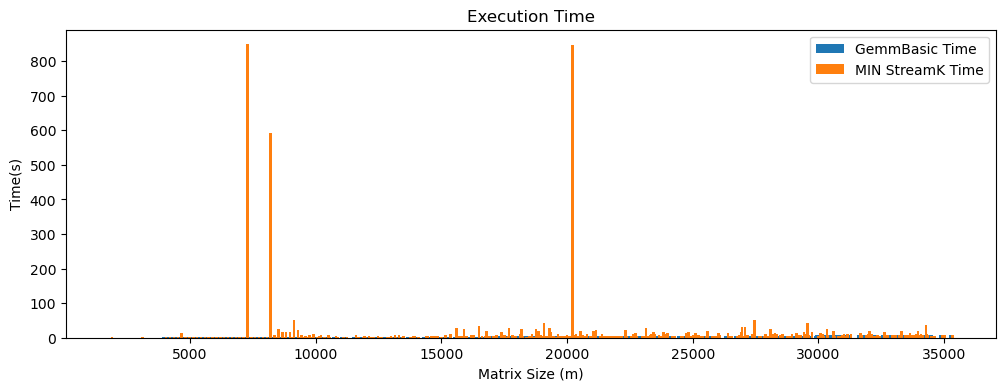

In [17]:
# 绘图
plt.figure(figsize=(12, 4))

# plt.plot(df_sorted['m'], df_sorted['gemm_basic_speedup'], label='GemmBasic Speedup', marker='o')
# plt.plot(df_sorted['m'], df_sorted['streamk_speedup'], label='StreamK Speedup', marker='o')
plt.bar(df_sorted['m'] - 50, df_sorted['gemm_basic_time'], width=100, label='GemmBasic Time', align='center')
plt.bar(df_sorted['m'] + 50, df_sorted['min_streamk_time'], width=100, label='MIN StreamK Time', align='center')

plt.title('Execution Time')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Time(s)')
plt.legend()

plt.show()

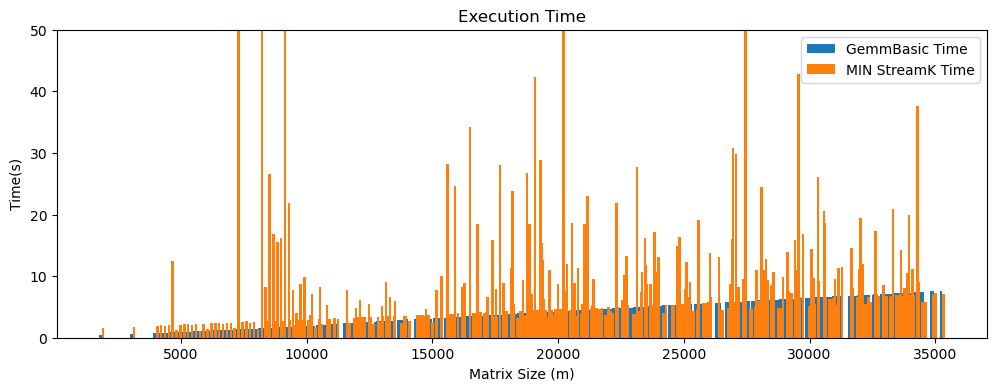

In [15]:
# 绘图
plt.figure(figsize=(12, 4))

# plt.plot(df_sorted['m'], df_sorted['gemm_basic_speedup'], label='GemmBasic Speedup', marker='o')
# plt.plot(df_sorted['m'], df_sorted['streamk_speedup'], label='StreamK Speedup', marker='o')
plt.bar(df_sorted['m'] - 50, df_sorted['gemm_basic_time'], width=100, label='GemmBasic Time', align='center')
plt.bar(df_sorted['m'] + 50, df_sorted['min_streamk_time'], width=100, label='MIN StreamK Time', align='center')

plt.title('Execution Time')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Time(s)')
plt.legend()
plt.ylim((0, 50))

plt.show()

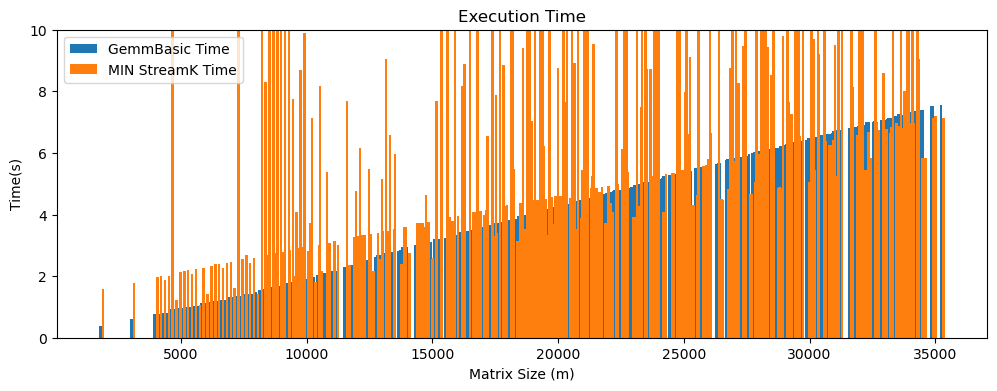

In [16]:
# 绘图
plt.figure(figsize=(12, 4))

# plt.plot(df_sorted['m'], df_sorted['gemm_basic_speedup'], label='GemmBasic Speedup', marker='o')
# plt.plot(df_sorted['m'], df_sorted['streamk_speedup'], label='StreamK Speedup', marker='o')
plt.bar(df_sorted['m'] - 50, df_sorted['gemm_basic_time'], width=100, label='GemmBasic Time', align='center')
plt.bar(df_sorted['m'] + 50, df_sorted['min_streamk_time'], width=100, label='MIN StreamK Time', align='center')

plt.title('Execution Time')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Time(s)')
plt.legend()
plt.ylim((0, 10))

plt.show()

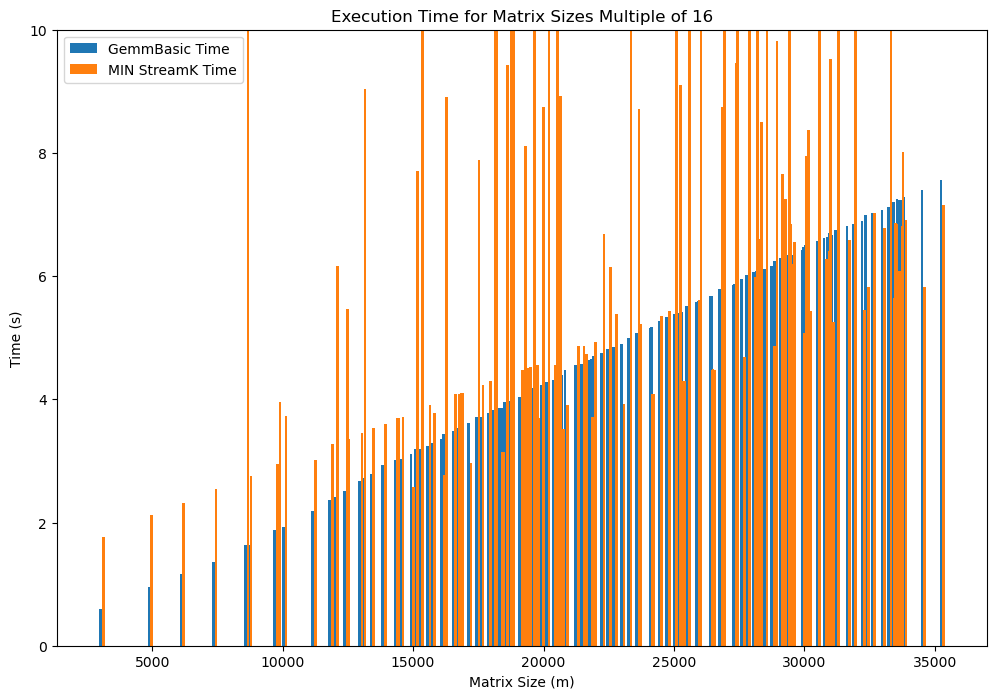

In [23]:
df_filtered = df_sorted[df_sorted['m'] % 16 == 0]

# 绘图
plt.figure(figsize=(12, 8))

# 绘制筛选后数据的执行时间
plt.bar(df_filtered['m'] - 50, df_filtered['gemm_basic_time'], width=100, label='GemmBasic Time', align='center')
plt.bar(df_filtered['m'] + 50, df_filtered['min_streamk_time'], width=100, label='MIN StreamK Time', align='center')

plt.title('Execution Time for Matrix Sizes Multiple of 16')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Time (s)')
plt.legend()
plt.ylim((0, 10))  # 设置y轴的范围

plt.show()

In [8]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 读取文件内容
with open('answer3.txt', 'r') as file:
    text = file.read()

# 使用正则表达式匹配数据
pattern = re.compile(r"Tested \d+/1000: Shape \((\d+), (\d+), (\d+)\), PyTorch Time ([\d.]+) ms, Best Triton Time ([\d.]+) ms, Speedup ([\d.]+), Max Discrepancy ([\d.]+)")
matches = pattern.findall(text)

# 将数据转换为DataFrame
data = []
for match in matches:
    m, n, k, pytorch_time, triton_time, speedup, max_disc = match
    data.append({
        'm': int(m),
        'n': int(n),
        'k': int(k),
        'pytorch_time': float(pytorch_time),
        'triton_time': float(triton_time),
        'speedup': float(speedup),
        'max_disc': float(max_disc)
    })
df = pd.DataFrame(data)

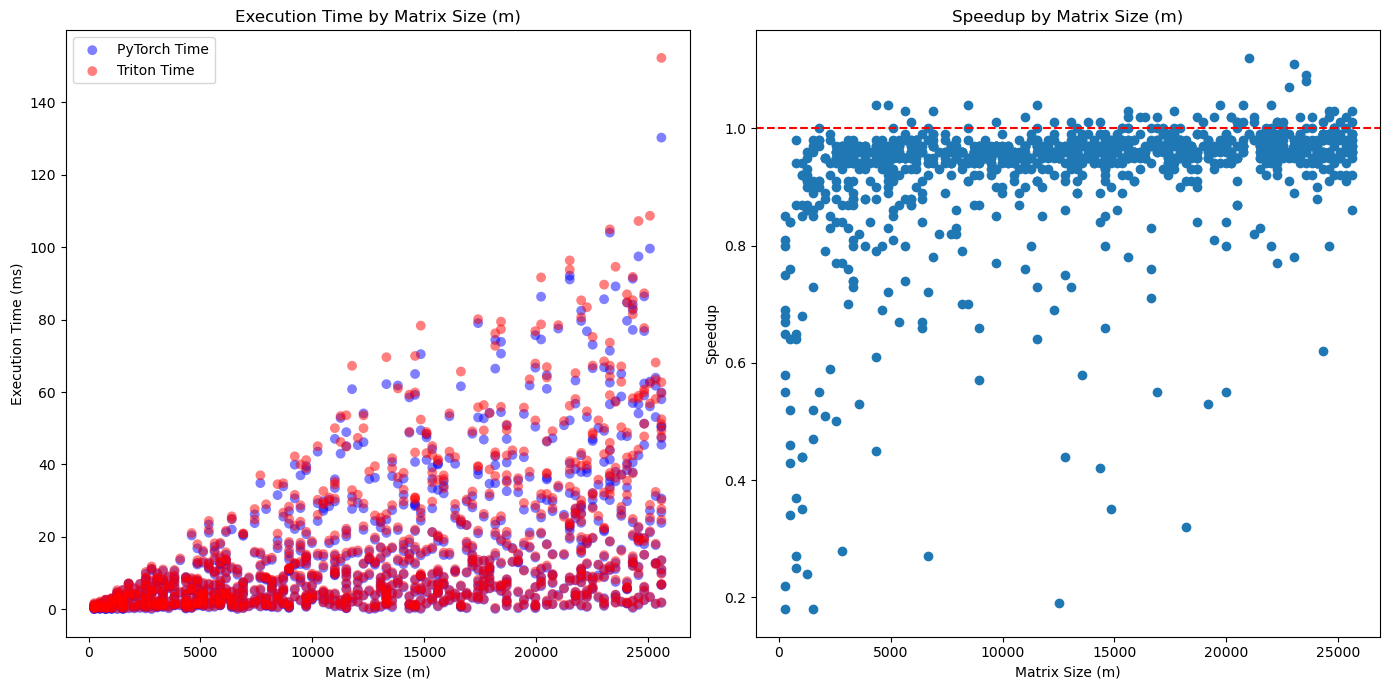

In [9]:
# 对DataFrame按照m、n、k进行排序
df_sorted = df.sort_values(by=['m', 'n', 'k'])
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 绘制PyTorch和Triton的执行时间
plt.subplot(1, 2, 1)
plt.scatter(df_sorted['m'], df_sorted['pytorch_time'], color='blue', alpha=0.5, label='PyTorch Time', edgecolor='none', s=50)
plt.scatter(df_sorted['m'], df_sorted['triton_time'], color='red', alpha=0.5, label='Triton Time', edgecolor='none', s=50)
plt.title('Execution Time by Matrix Size (m)')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Execution Time (ms)')
plt.legend()

# 绘制加速比
plt.subplot(1, 2, 2)
plt.scatter(df_sorted['m'], df_sorted['speedup'])
plt.title('Speedup by Matrix Size (m)')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Speedup')
plt.axhline(y=1.0, color='red', linestyle='--')

plt.tight_layout()
plt.show()


Results with Speedup > 1:
         m      n      k  pytorch_time  triton_time  speedup  max_disc
814  20992   1024  18944          3.96         3.55     1.12     0.500
804  23040   1024  13312          3.09         2.79     1.11     0.500
633  23552   1280   6400          1.97         1.81     1.09     0.625
844  23552   1024  14336          3.39         3.14     1.08     0.500
407  22784  14848   3072          9.40         8.78     1.07     0.250
0     4352  15872  15104          8.90         8.52     1.04     1.000
660   8448   2304  25600          4.31         4.15     1.04     1.000
52   11520   2304  25088          5.69         5.46     1.04     1.000
719  22016  13056   6912         17.08        16.43     1.04     0.250
483  20736   2816  19200          9.50         9.17     1.04     0.500
685   4864   9984   9216          4.04         3.90     1.04     0.500
542  19712  12032  10496         21.24        20.43     1.04     0.750
813  17664  16640   3072          7.89         7.69

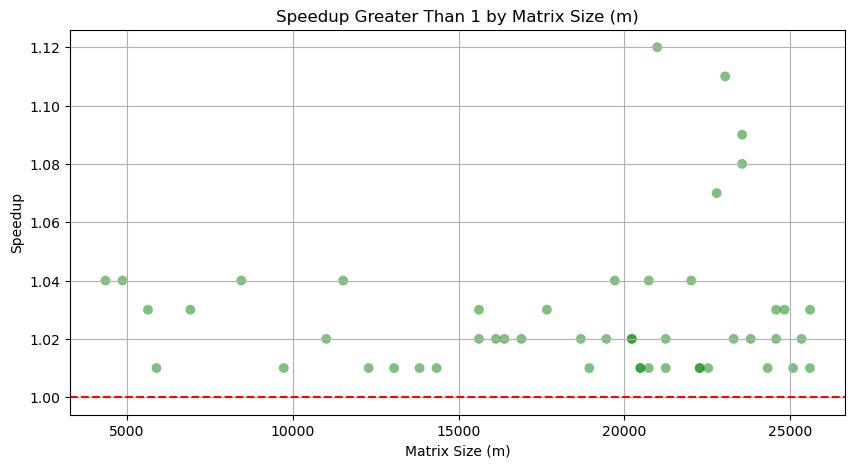

In [16]:
df_accelerated = df_sorted[df_sorted['speedup'] > 1]
df_accelerated = df_accelerated.sort_values(by=['speedup'], ascending=False)  # 设置为倒序

# 打印筛选后的结果
if not df_accelerated.empty:
    print("Results with Speedup > 1:")
    print(df_accelerated[['m', 'n', 'k', 'pytorch_time', 'triton_time', 'speedup', 'max_disc']])
else:
    print("No results with speedup greater than 1.")

import matplotlib.pyplot as plt

# 绘制加速比大于1的结果
plt.figure(figsize=(10, 5))
plt.scatter(df_accelerated['m'], df_accelerated['speedup'], color='green', alpha=0.5, edgecolor='none', s=50)
plt.title('Speedup Greater Than 1 by Matrix Size (m)')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Speedup')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.grid(True)
plt.show()


In [27]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 读取文件内容
with open('answer7.txt', 'r') as file:
    text = file.read()

# 使用正则表达式匹配数据
pattern = re.compile(r"Tested \d+/1000: Shape \((\d+), (\d+), (\d+)\), PyTorch Time ([\d.]+) ms, Best Triton Time ([\d.]+) ms, Speedup ([\d.]+), Max Discrepancy ([\d.]+)")
matches = pattern.findall(text)

# 将数据转换为DataFrame
data = []
for match in matches:
    m, n, k, pytorch_time, triton_time, speedup, max_disc = match
    data.append({
        'm': int(m),
        'n': int(n),
        'k': int(k),
        'pytorch_time': float(pytorch_time),
        'triton_time': float(triton_time),
        'speedup': float(speedup),
        'max_disc': float(max_disc)
    })
df = pd.DataFrame(data)

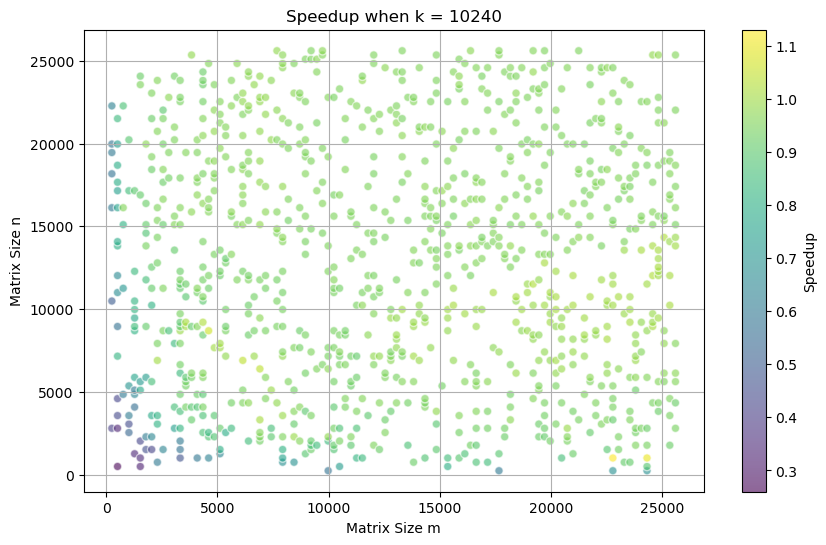

In [28]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['m'], df['n'], c=df['speedup'], cmap='viridis', alpha=0.6, edgecolors='w')
plt.colorbar(sc, label='Speedup')
plt.title('Speedup when k = 10240')
plt.xlabel('Matrix Size m')
plt.ylabel('Matrix Size n')
plt.grid(True)  # 添加网格线以便更好地定位点
plt.show()